# Yelp API - Lab


## Introduction 

Now that we've seen how the Yelp API works and some basic Folium visualizations, it's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 
* Create HTTP requests to get data from Yelp API
* Parse HTTP responses and perform data analysis on the data returned
* Perform pagination to retrieve troves of data!
* Create a simple geographical system on to view information about selected businesses, at a given location. 

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you, but make the request below.

In [34]:
import requests
import folium
import pandas as pd
from pprint import pprint

In [5]:
#Your code here
api_key = 'doGWt0kZaYzy5wUD9M2ASv1qaLHLa_JcGtZkQMK0lfxjyxHL4t5HiAkzMjAo7WTUidg19uKYv2YTK_-_SwmgCtKvRBA_iCAyWLPQd0r0uCqaeZOPo2AqhNfVTF_5XHYx'

term = 'Pub'
location = 'Cambridge UK'

url = 'https://api.yelp.com/v3/businesses/search'
headers = { 'Authorization': 'Bearer {}'.format(api_key), }

url_params = { 'term': term.replace(' ','+'), 
               'location': location.replace(' ','+')
             }

response = requests.get(url,headers=headers,params=url_params)
print(response)

<Response [200]>


In [30]:
response.json().keys()

dict_keys(['businesses', 'total', 'region'])

## Pagination

Now that you have an initial response, you can examine the contents of the json container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day, and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [38]:
# Your code here; use a function or loop to retrieve all the results from your original request
total_businesses = response.json()['total']
total_businesses
#pd.DataFrame(response.json()['businesses'])

125

In [41]:
#Set limit to 50 - This is the maximum that Yelp will allow for a return from a get request
limit = 50

#update url_params with limit
url_params = { 'term': term.replace(' ','+'), 
               'location': location.replace(' ','+'),
               'limit': limit
             }

#The number of get calls required is going to be the ceiling of total records divided by the return amount.
num_gets = (total_businesses//limit) + (total_businesses%limit > 0)
num_gets

3

In [63]:
len(response.json()['businesses'])

20

In [65]:
#list that will contain all of the records from the search
results = []

#Run loop for the number of requests that we need
for i in range(num_gets):
    #update the offset parameter
    offset = limit * i
    
    #update offset value in url_params
    url_params['offset'] = offset
    
    #Get the data
    resp = requests.get(url,headers=headers,params=url_params)
    
    #See if request was successful
    successful = (resp.status_code == requests.codes.ok)
    
    #See how many records were retrieved
    num_records = len(resp.json()['businesses'])
    
    #append the results to a list of dictionaries
    results += resp.json()['businesses']
    
    #Print some stuff so that I can see what happened in each cycle
    print('Request #{}, Success: {}, Num_records: {}'.format(i+1, successful, num_records))

Request #1, Success: True, Num_records: 50
Request #2, Success: True, Num_records: 50
Request #3, Success: True, Num_records: 25


In [85]:
#Categories, coordinates, location are all dictionaries. Will need to get the data out.

#categories is a list of dictionaries with the keys 'alias' and 'title'. Title is just the alias capitalized.

#coordinates is a dictionary containing keys 'latitude' and 'longitude'

#location is a dictionary with the address. There are many keys. I'm going to take address1, city, country

pprint(results[0])

{'alias': 'pint-shop-cambridge',
 'categories': [{'alias': 'british', 'title': 'British'}],
 'coordinates': {'latitude': 52.2041657823304, 'longitude': 0.118927448689301},
 'display_phone': '+44 1223 352293',
 'distance': 598.9472687186371,
 'id': 'ij3rkfAPdHwpiW7Ue9EBYw',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/Qy7N_hwdm-rXT8tRr-HrBQ/o.jpg',
 'is_closed': False,
 'location': {'address1': '10 Peas Hill',
              'address2': '',
              'address3': '',
              'city': 'Cambridge',
              'country': 'GB',
              'display_address': ['10 Peas Hill',
                                  'Cambridge CB2 3PN',
                                  'United Kingdom'],
              'state': 'CAM',
              'zip_code': 'CB2 3PN'},
 'name': 'Pint Shop',
 'phone': '+441223352293',
 'price': '££',
 'rating': 4.5,
 'review_count': 57,
 'transactions': [],
 'url': 'https://www.yelp.com/biz/pint-shop-cambridge?adjust_creative=ymFuo5TTNWWadm7w1AHxuQ&utm_campa

In [115]:

#categories = [ category['title'] for category in results[0]['categories'] ]


results[19]

{'id': 'PEbBGRRBRlIjU3T49s_-Uw',
 'alias': 'six-bells-cambridge',
 'name': 'Six Bells',
 'image_url': 'https://s3-media3.fl.yelpcdn.com/bphoto/zY4X_Nv59o-wuLEQv2dHRA/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/six-bells-cambridge?adjust_creative=ymFuo5TTNWWadm7w1AHxuQ&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=ymFuo5TTNWWadm7w1AHxuQ',
 'review_count': 3,
 'categories': [{'alias': 'pubs', 'title': 'Pubs'}],
 'rating': 3.5,
 'coordinates': {'latitude': 52.2001596, 'longitude': 0.1343473},
 'transactions': [],
 'location': {'address1': '11 Covent Garden',
  'address2': '',
  'address3': '',
  'city': 'Cambridge',
  'zip_code': 'CB1 2HS',
  'country': 'GB',
  'state': 'CAM',
  'display_address': ['11 Covent Garden',
   'Cambridge CB1 2HS',
   'United Kingdom']},
 'phone': '+441223355559',
 'display_phone': '+44 1223 355559',
 'distance': 626.9643290588936}

In [117]:
#This will contain a list of dictionaries that will have all of the data I want
dict_list_of_results = []

#loop through all results and get the info out that I want
for result in results:
    #empty dictionary to populate
    d = {}
    d['name'] = result['name']
    d['categories'] = categories = [ category['title'] for category in result['categories'] ]
    d['lat'] = result['coordinates']['latitude']
    d['long'] = result['coordinates']['longitude']
    d['phone_num'] = result['display_phone']
    d['address'] = result['location']['address1']
    d['city'] = result['location']['city']
    d['country'] = result['location']['country']
    
    #one of the records did not have a price key. Used get function to make it an empty string for that one.
    d['price'] = result.get('price','')
    
    d['rating'] = result['rating']
    d['review_count'] = result['review_count']
    dict_list_of_results.append(d)

In [118]:
#Make a dataframe of the results
cambridge_pubs_df = pd.DataFrame(dict_list_of_results)
cambridge_pubs_df.head()

,address,categories,city,country,lat,long,name,phone_num,price,rating,review_count
0,10 Peas Hill,[British],Cambridge,GB,52.204166,0.118927,Pint Shop,+44 1223 352293,££,4.5,57
1,Benet Street,[Pubs],Cambridge,GB,52.204154,0.118593,Eagle Public House,+44 1223 505020,££,4.0,99
2,7 Prospect Row,"[Pubs, British]",Cambridge,GB,52.204808,0.130396,The Free Press,+44 1223 368337,£££,4.5,35
3,106 Hills Rd,[Pubs],Cambridge,GB,52.194205,0.131289,Flying Pig,+44 1223 354623,£,5.0,9
4,1 King Street,[Breweries],Cambridge,GB,52.207461,0.122366,The Cambridge Brew House,+44 1223 855185,££,3.5,26


## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

££      67
        31
£       14
£££     12
££££     1
Name: price, dtype: int64


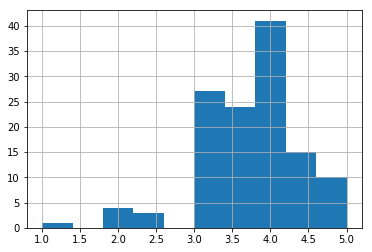

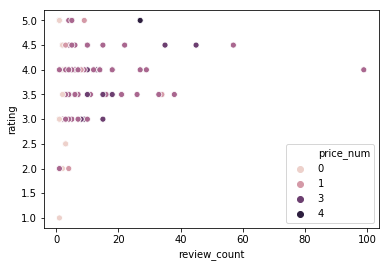

In [156]:
#Your code here
import matplotlib.pyplot as plt
import seaborn as sns

cambridge_pubs_df['price_num'] = cambridge_pubs_df['price'].map(lambda x: len(x))

print(cambridge_pubs_df['price'].value_counts())

cambridge_pubs_df['rating'].hist(bins=10)
plt.show()

sns.scatterplot(x='review_count',y='rating',hue='price_num', data=cambridge_pubs_df)

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [160]:
cambridge_pubs_df.head()

,address,categories,city,country,lat,long,name,phone_num,price,rating,review_count,price_num
0,10 Peas Hill,[British],Cambridge,GB,52.204166,0.118927,Pint Shop,+44 1223 352293,££,4.5,57,2
1,Benet Street,[Pubs],Cambridge,GB,52.204154,0.118593,Eagle Public House,+44 1223 505020,££,4.0,99,2
2,7 Prospect Row,"[Pubs, British]",Cambridge,GB,52.204808,0.130396,The Free Press,+44 1223 368337,£££,4.5,35,3
3,106 Hills Rd,[Pubs],Cambridge,GB,52.194205,0.131289,Flying Pig,+44 1223 354623,£,5.0,9,1
4,1 King Street,[Breweries],Cambridge,GB,52.207461,0.122366,The Cambridge Brew House,+44 1223 855185,££,3.5,26,2


In [168]:
#Your code here

#center of map - Cambridge UK
lat = 52.2021790
long = 0.1281774

base_map = folium.Map([lat,long],zoom_start=13)

for idx, pub in cambridge_pubs_df.iterrows():
    pub_lat = pub['lat']
    pub_long = pub['long']
    pub_name = pub['name']
    pub_address = pub['address']
    pub_city = pub['city']
    pub_phone = pub['phone_num']
    pub_rating = pub['rating']
    pub_food_type = ' '.join(pub['categories'])
    
    #make a nice popup message from this stuff
    popup_msg = f'{pub_name}\n{pub_address}\n{pub_city}\n{pub_phone}\nType: {pub_food_type}\nRating: {pub_rating}\n'
    
    #make the folium marker with popup message
    popup = folium.Popup(popup_msg, parse_html=True)
    marker = folium.Marker(location=[pub_lat,pub_long], popup=popup)
    marker.add_to(base_map)

base_map


## Summary

Nice work! In this lab, you synthesized your skills for the day, making multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice map visual to display the results! Well done!